## Bitcoin Prediction
#### Model to predict the price of Bitcoin (BTC)
#### Machine Learning Algorithm: **XGBoost**, **LSTM**, **SVM**

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import json

import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
#from keras.models import Sequential
#from keras.layers import LSTM, Dense

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Visualise Dataset

In [3]:
data_df = pd.read_csv("../price-prediction/BTC-USD.csv")
data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
def data_summary(df, message):
    ''' Returns a summary data in the df'''
    
    print(f'{message}:\n')
    print('Number of rows: ', df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nData Features:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [5]:
data_summary(data_df, 'Overview of the dataset')

Overview of the dataset:

Number of rows:  2713

Number of features: 7

Data Features:
['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

Missing values: 0

Unique values:
Date         2713
Open         2709
High         2710
Low          2712
Close        2710
Adj Close    2710
Volume       2713
dtype: int64


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 148.5+ KB


#### Figure 1: Plot BTC Closing Price over time

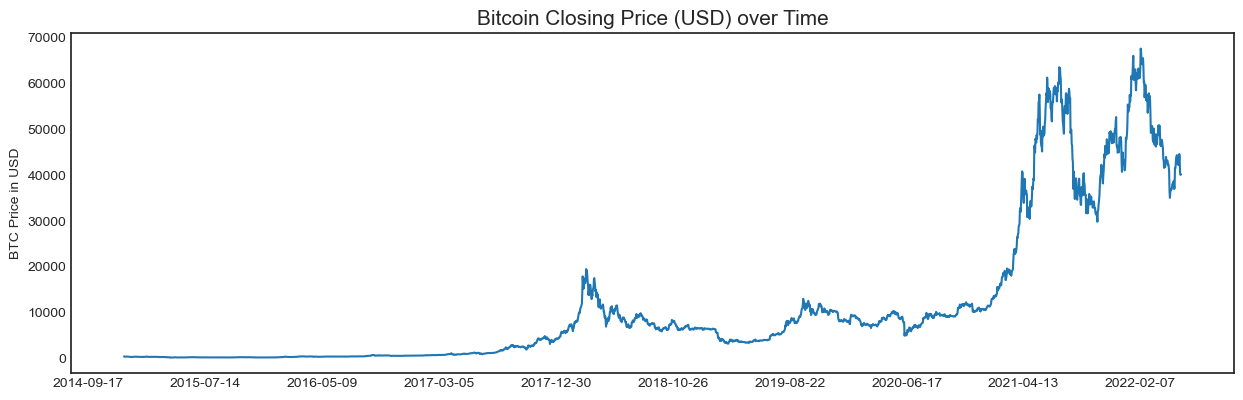

In [7]:
plt.style.use('seaborn-white')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

plt.figure(figsize=(15, 5))

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.gcf().autofmt_xdate(rotation=0)

plt.plot(data_df['Date'], data_df['Close'])
plt.title('Bitcoin Closing Price (USD) over Time', fontsize=15)
plt.ylabel('BTC Price in USD')
plt.show()

Check for any duplicate columns and remove these

In [8]:
data_df.T.duplicated()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close     True
Volume       False
dtype: bool

In [9]:
duplicated_cols = data_df.columns[data_df.T.duplicated()]
data_df = data_df.drop(columns=duplicated_cols, axis=1)

In [10]:
data_df.head()

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [11]:
#pd.DataFrame.drop?

#### Figure 2: Plot distribution for Open, High, Low and Close features

In [12]:
data_df.iloc[:, 1:].columns.tolist()

['Open', 'High', 'Low', 'Close', 'Volume']

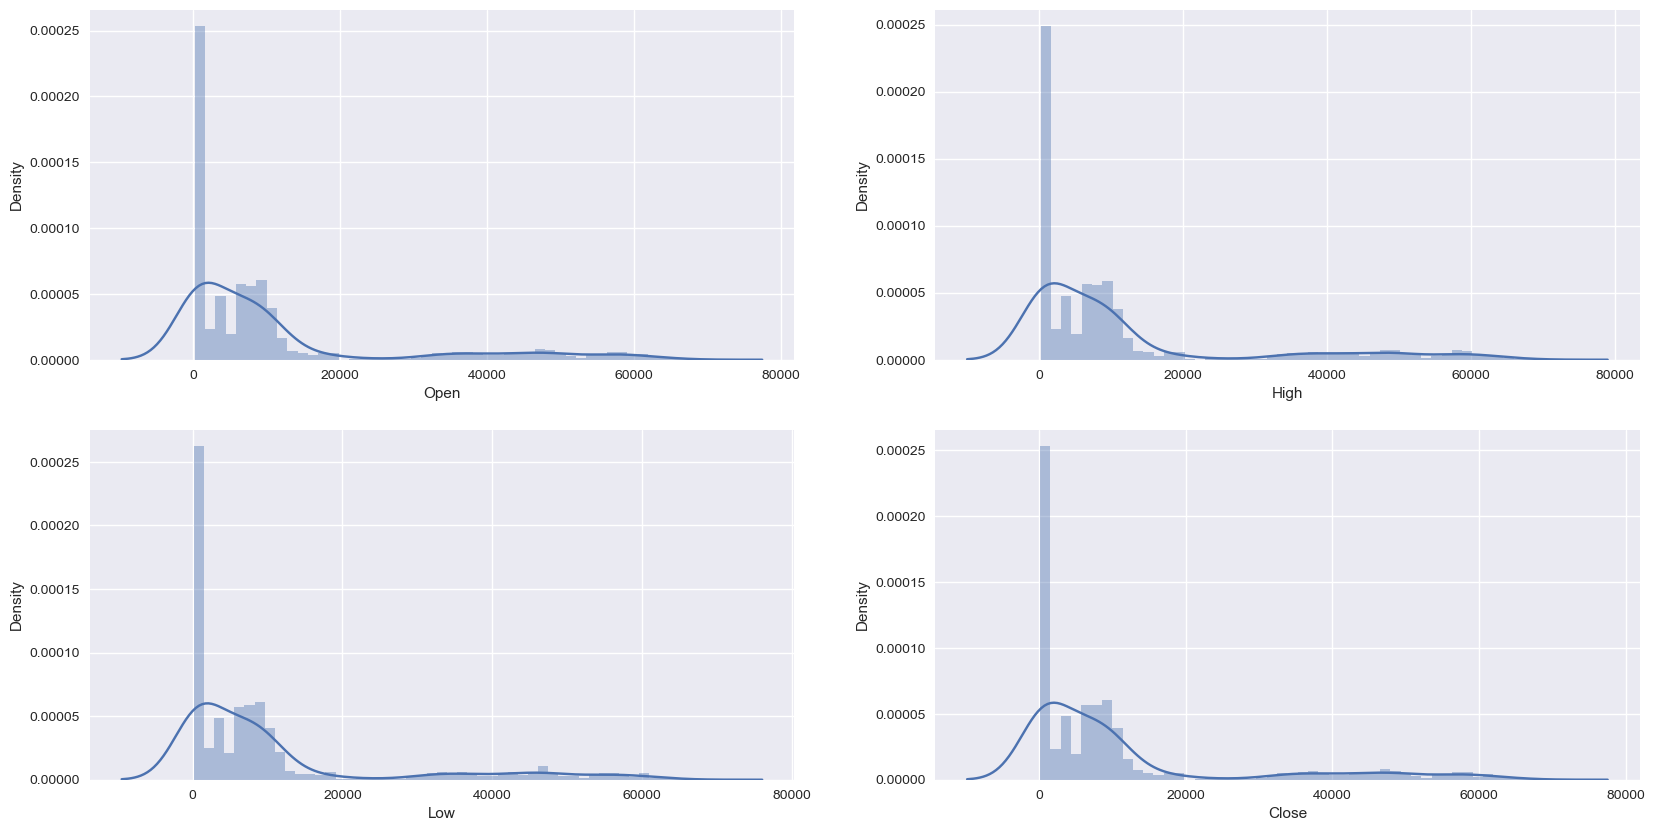

In [13]:
features = data_df.iloc[:, 1:-1].columns.tolist()
plt.style.use('seaborn')

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.distplot(data_df[col])
plt.show()

#### Figure 3: Box Plot for Features to Understand the Outliers

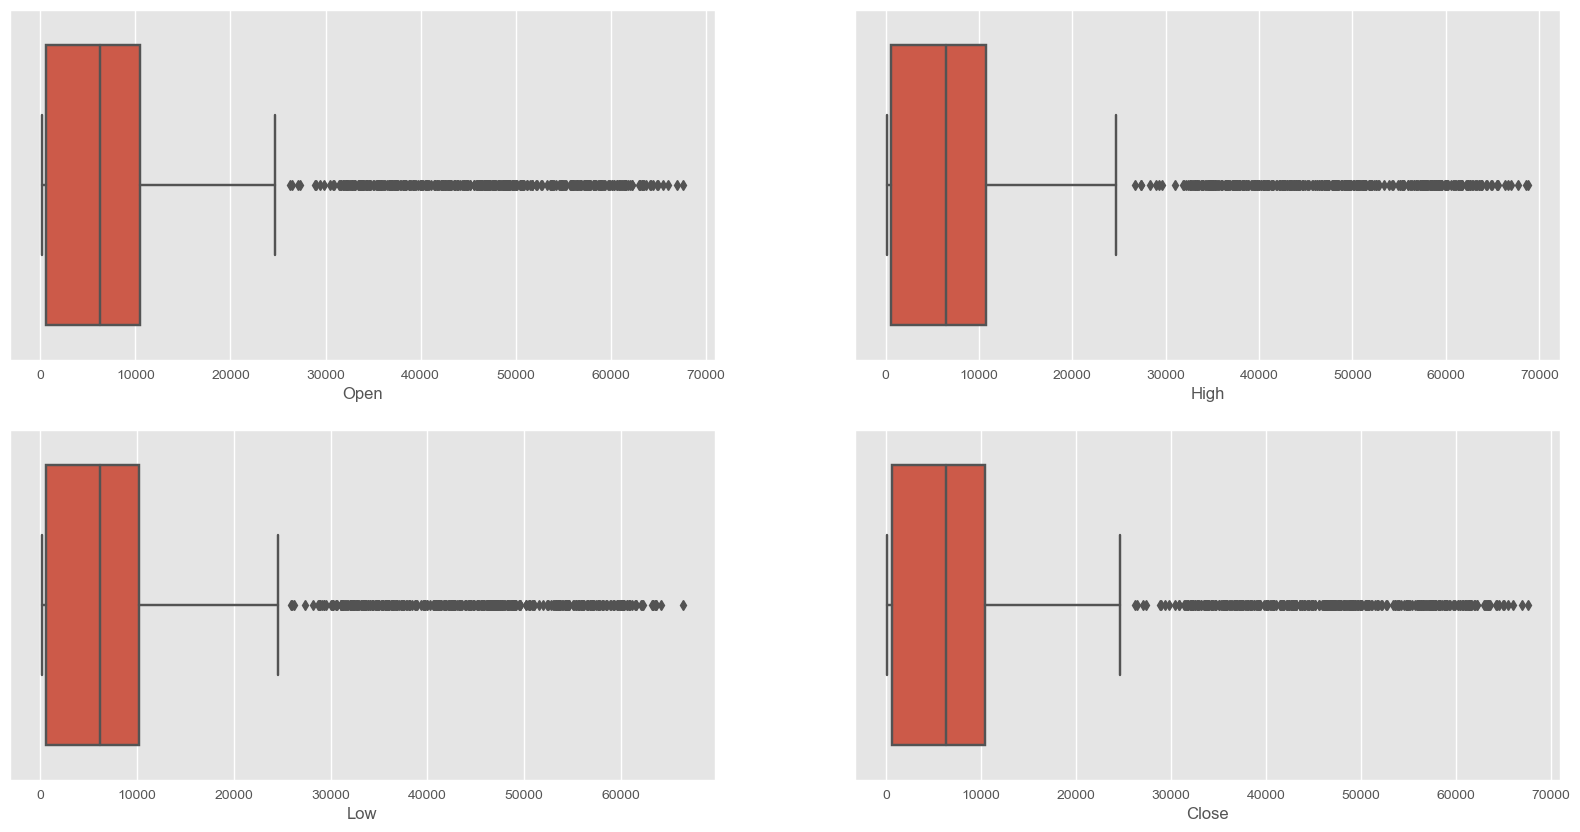

In [14]:
plt.subplots(figsize=(20,10))
plt.style.use('ggplot')
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.boxplot(data_df[col])
plt.show()

Many outliers present for all features (Open, High, Low and Close)

## Feature Enginering

Convert 'Date' column to date and create new features for date parts

In [15]:
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df['Year'] = data_df['Date'].dt.year
data_df['Month'] = data_df['Date'].dt.month
data_df['Day'] = data_df['Date'].dt.day

data_df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


Group data by year and take the average

In [16]:
df_grouped = data_df.groupby('Year').mean()
df_grouped

,Open,High,Low,Close,Volume,Month,Day
Year,,,,,,,
2014,365.058217,373.265397,355.903726,363.693085,2.383690e+07,10.735849,16.849057
2015,272.149011,278.151978,266.807891,272.453381,3.390557e+07,6.526027,15.720548
2016,567.141429,574.302273,560.453374,568.492407,8.592451e+07,6.513661,15.756831
2017,3970.644848,4144.687445,3811.707792,4006.033629,2.382867e+09,6.526027,15.720548
2018,7601.018680,7787.978969,7350.747939,7572.298947,6.063552e+09,6.526027,15.720548
2019,7385.218456,7549.907409,7222.602868,7395.246282,1.673049e+10,6.526027,15.720548
2020,11056.787201,11304.359035,10844.595163,11116.378092,3.302327e+10,6.513661,15.756831
2021,47402.115663,48762.998925,45852.003082,47436.932021,4.715574e+10,6.526027,15.720548
2022,41468.636797,42225.196172,40415.898360,41345.687735,2.718684e+10,1.380000,13.720000


#### Figure 4: Bar Charts for Each Feature Average per Year

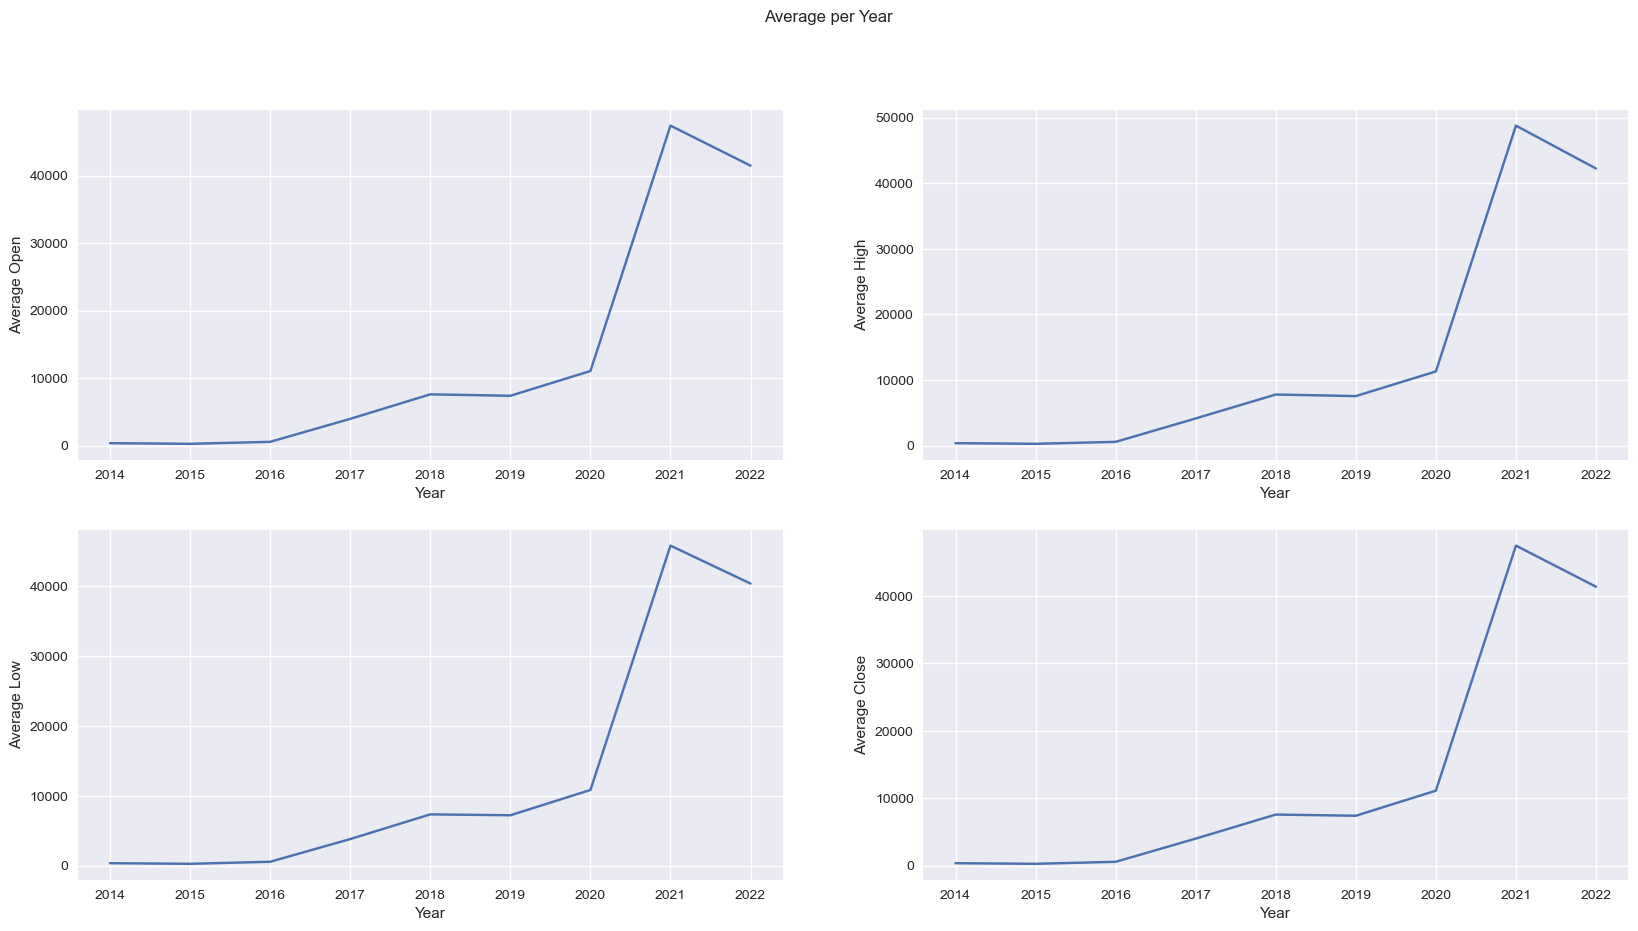

In [17]:
plt.subplots(figsize=(20,10))
plt.style.use('seaborn')

for position, feature in enumerate(features):
    
    ax = plt.subplot(2, 2, position+1)
    df_grouped[feature].plot.line(ax=ax)
    ax.set_xlabel('Year') 
    ax.set_ylabel('Average '+ feature) 
plt.suptitle('Average per Year') 
plt.show()

In [18]:
data_df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


- Add additional features for Change in Price ['Daily Change'] 
- Price Range for the day ['Daily Range']
- Target to for the price is going to increase

In [19]:
data_df['Is Quarter End'] = np.where(data_df['Month']%3==0,1,0)
data_df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Day,Is Quarter End
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1


In [20]:
data_df['Daily Change'] = data_df['Open'] - data_df['Close']
data_df['Daily Range'] = data_df['High'] - data_df['Low']
data_df['Target'] = np.where(data_df['Close'].shift(-1) > data_df['Close'], 1, 0)
data_df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Day,Is Quarter End,Daily Change,Daily Range,Target
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1,8.529999,15.752014,0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1,32.419983,43.755981,0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1,29.307007,43.302978,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1,-14.230988,33.412994,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1,9.263977,19.244995,1


#### Figure 5: Pie Chart to Check if Target is balanced

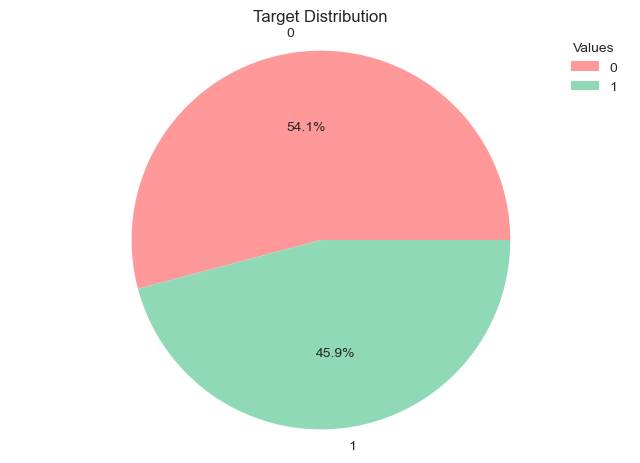

In [21]:
colours = ['#ff9999', '#8fd9b6']

plt.pie(data_df['Target'].value_counts().values
        , labels=[0, 1]
        , colors=colours
        , autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Target Distribution')
plt.legend(title='Values', loc='best')
plt.show()

Check if any of the numeric fields are correlated

In [22]:
corr_matrix = data_df.corr()

<AxesSubplot:>

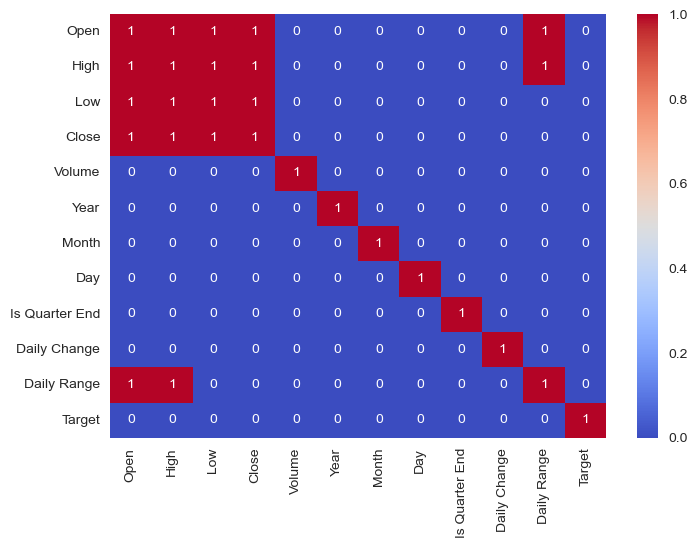

In [23]:
sns.heatmap(corr_matrix > 0.8, annot=True, cmap='coolwarm')

Remove the unnecessary features

In [24]:
data_df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Day,Is Quarter End,Daily Change,Daily Range,Target
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1,8.529999,15.752014,0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1,32.419983,43.755981,0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1,29.307007,43.302978,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1,-14.230988,33.412994,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1,9.263977,19.244995,1


# Modeling

Split Target `y` and Features `X`

In [25]:
X = data_df[['Volume', 'Daily Change', 'Daily Range', 'Is Quarter End']]
y = data_df['Target']

 Divide data into training and validation subsets

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y,
                                                                random_state=42)

In [28]:
X_train

,Volume,Daily Change,Daily Range,Is Quarter End
175,33963900,-4.854004,6.882995,1
1443,4463250000,65.529786,238.000000,0
1109,1207449984,-172.600098,197.570313,1
865,60851700,2.571045,4.270020,0
320,21474100,1.579010,5.238006,0
...,...,...,...,...
2585,51780081801,-4248.046875,5888.984375,0
23,43665700,3.125000,22.103973,0
1893,21008924418,-101.632324,290.840820,0
682,38456100,1.965027,4.014038,0


Ordinal Features: `Is Quarter End`

Scaled Features: `Volume`, `Daily Change`, `Daily Range`

In [29]:
# Scale necessary features so that they don't dominate over others
scaler = StandardScaler()
scale_columns = ['Volume', 'Daily Change', 'Daily Range']
X_train[scale_columns] = scaler.fit_transform(X_train[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])
X_train

,Volume,Daily Change,Daily Range,Is Quarter End
175,-0.713441,-0.000773,-0.530397,1
1443,-0.492606,0.094600,-0.326057,0
1109,-0.654933,-0.228078,-0.361803,1
865,-0.712100,0.009288,-0.532707,0
320,-0.714063,0.007944,-0.531851,0
...,...,...,...,...
2585,1.866506,-5.750506,4.670189,0
23,-0.712957,0.010039,-0.516939,0
1893,0.332325,-0.131913,-0.279339,0
682,-0.713217,0.008467,-0.532933,0


Data is clean and ready to be used in ML models

### Create Functions to train using each Algorithm

In [30]:
def logistic_regression(X_train, y_train, X_test, y_test, ConfusionMatrixDisplay=False):
    """Train Logistic Regression model and return model and f1-score."""
    
    model = LogisticRegression(solver='lbfgs', random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    
    pred_y = model.predict(X_test)
    score = f1_score(y_test, pred_y)
    classification_report(y_test, pred_y)
    
    fpr, tpr, _ = roc_curve(y_test, pred_y)
    roc_auc = auc(fpr, tpr)
    
    print("Logistic Regression report:\n", classification_report(y_test, pred_y))
    return model, score

In [31]:
logistic_regression(X_train, y_train, X_test, y_test)

Logistic Regression report:
               precision    recall  f1-score   support

           0       0.50      0.55      0.52       249
           1       0.58      0.53      0.56       294

    accuracy                           0.54       543
   macro avg       0.54      0.54      0.54       543
weighted avg       0.54      0.54      0.54       543



(LogisticRegression(class_weight='balanced', random_state=42),
 0.5567375886524824)

In [34]:
def svm(X_train, y_train, X_test, y_test, ConfusionMatrixDisplay=False):
    """Train Support Vector Machine model and return model and f1-score."""
    
    model = SVC(kernel='poly', gamma=0.1, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    
    pred_y = model.predict(X_test)
    score = f1_score(y_test, pred_y)    
    classification_report(y_test, pred_y)
    
    print("Support Vector Machine report:\n", classification_report(y_test, pred_y))
    return model, score

In [35]:
svm(X_train, y_train, X_test, y_test)

Support Vector Machine report:
               precision    recall  f1-score   support

           0       0.62      0.02      0.04       249
           1       0.54      0.99      0.70       294

    accuracy                           0.55       543
   macro avg       0.58      0.50      0.37       543
weighted avg       0.58      0.55      0.40       543



(SVC(class_weight='balanced', gamma=0.1, kernel='poly', random_state=42),
 0.7020506634499397)

In [54]:
def xgboost(X_train, y_train, X_test, y_test, ConfusionMatrixDisplay=False):
    """Train K-Nearest Neighbors model and return model and f1-score."""
    
    model = XGBClassifier(objective='reg:squarederror', learning_rate=0.05)
    model.fit(X_train, y_train)
    
    pred_y = model.predict(X_test)
    score = f1_score(y_test, pred_y)    
    classification_report(y_test, pred_y)
    
    print("XGBoost report:\n", classification_report(y_test, pred_y))
    return model, score

In [55]:
xgboost(X_train, y_train, X_test, y_test)

XGBoost report:
               precision    recall  f1-score   support

           0       0.46      0.36      0.40       249
           1       0.54      0.65      0.59       294

    accuracy                           0.51       543
   macro avg       0.50      0.50      0.50       543
weighted avg       0.51      0.51      0.50       543



(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, ...),
 0.5900621118012424)

In [38]:
def get_confusion_matrix(svm_cm, xgboost_cm, logreg_cm):
    """Creates plots for confusion matrix."""
    
    # Create confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
    sns.heatmap(svm_cm, annot=True, ax=ax[0], cmap='Blues', fmt='g')
    ax[0].set_title('Support Vector Machine')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('True')
    
    sns.heatmap(xgboost_cm, annot=True, ax=ax[1], cmap='Blues', fmt='g')
    ax[1].set_title('XGBoost')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('True')
    
    sns.heatmap(logreg_cm, annot=True, ax=ax[2], cmap='Blues', fmt='g')
    ax[2].set_title('Logistic Regression')
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('True')

In [56]:
def test_models():
    """Determine which model performs the best based on the f1-score evaluation metric
    Returns best model."""
    
    # Train models and obtain f1 evaluation scores
    model_scores = {}
    logreg_model, model_scores['Logistic Regression'] = logistic_regression(X_train, y_train, X_test, y_test)
    svm_model, model_scores['Support Vector Machine'] = svm(X_train, y_train, X_test, y_test)
    xgboost_model, model_scores['XGBoost'] = xgboost(X_train, y_train, X_test, y_test)
    
    # Create confusion matrix to visualise performance
    svm_cm = confusion_matrix(y_test, svm_model.predict(X_test))
    xgboost_cm = confusion_matrix(y_test, xgboost_model.predict(X_test))
    logreg_cm = confusion_matrix(y_test, logreg_model.predict(X_test))
    get_confusion_matrix(svm_cm, xgboost_cm, logreg_cm)
        
    # Find best model
    best_model = ''
    best_score = 0
    for key, value in model_scores.items():
        if value == max(model_scores.values()):
            best_model = key
            best_score = value
    
    print(f"\nThe best model is {best_model} with an f1-score of {best_score:.3f}")
    
    if best_model == 'Support Vector Machine':
        return svm_model
    elif best_model == 'Logistic Regression':
        return logreg_model
    else:
        return xgboost_model

Call test_model function to get best model and obtain visualisation for performance

Logistic Regression report:
               precision    recall  f1-score   support

           0       0.50      0.55      0.52       249
           1       0.58      0.53      0.56       294

    accuracy                           0.54       543
   macro avg       0.54      0.54      0.54       543
weighted avg       0.54      0.54      0.54       543

Support Vector Machine report:
               precision    recall  f1-score   support

           0       0.62      0.02      0.04       249
           1       0.54      0.99      0.70       294

    accuracy                           0.55       543
   macro avg       0.58      0.50      0.37       543
weighted avg       0.58      0.55      0.40       543

XGBoost report:
               precision    recall  f1-score   support

           0       0.46      0.36      0.40       249
           1       0.54      0.65      0.59       294

    accuracy                           0.51       543
   macro avg       0.50      0.50      0.50       

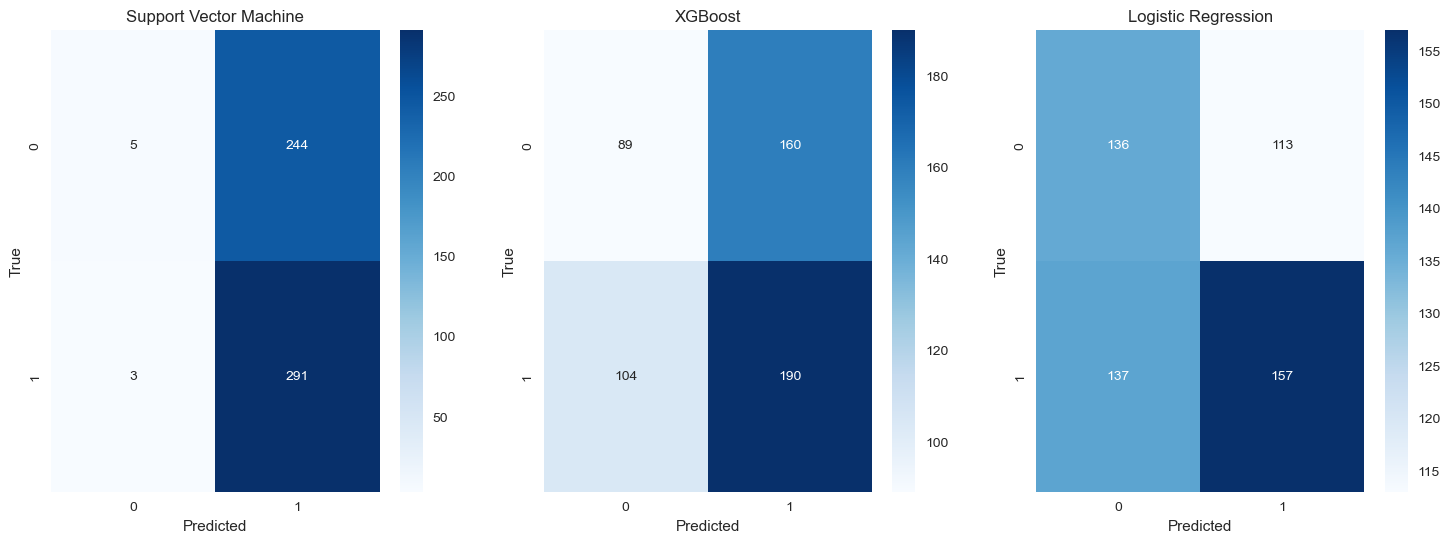

In [57]:
best_model = test_models()

# Save Model

In [41]:
mkdir -p models/svm

In [42]:
model_params = best_model.get_params()
print(model_params)

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [43]:
json.dump(model_params, open("models/svm/params.json", "w"), indent=4)

In [44]:
model_path = "models/svm/dt.joblib"
joblib.dump(best_model, model_path)

['models/svm/dt.joblib']